In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gensim
import gensim.downloader as gensim_downloader
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import scipy
import _pickle as pickle
import seaborn as sns
import tensorflow as tf
from keras.layers import Permute, Dense, multiply, Input, Embedding, Bidirectional, LSTM
from keras.models import Model


In [4]:
df = pd.read_csv("data/covid19_articles_20201231_reduced.csv")

WE_BIGRAM_PHRASER_FILEPATH = "we_bigram_phraser.pkl"
bigram_phraser = pickle.load(open(WE_BIGRAM_PHRASER_FILEPATH, "rb"))

nlp = gensim_downloader.load("word2vec-google-news-300")


In [5]:
## Tokenizer taken from TensorFLow
## https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer()


In [6]:
MAX_LENGTH = 15
_ = []
for sen in df["content"]:
    w = sen.split()
    _.append(w)
## get bigrams
_ = list(bigram_phraser[_])
## fit tokenizer
tokenizer.fit_on_texts(_)
## create sequences
seqences = tokenizer.texts_to_sequences(_)

X = tf.keras.preprocessing.sequence.pad_sequences(
    seqences, maxlen=MAX_LENGTH, padding="post", truncating="post"
)

y = df.iloc[:, -1]

y_map = {a: b for a, b in enumerate(np.unique(y))}
y_map_reverse = {b: a for a, b in y_map.items()}
y = np.array([y_map_reverse[a] for a in y])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=69
)


In [7]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(37752, 15)
(37752,)
(9439, 15)
(9439,)


In [8]:
## create embeddings using nlp model
we_embeddings = np.zeros((len(tokenizer.word_index) + 1, 300))
for w, i in tokenizer.word_index.items():
    try:
        we_embeddings[i] = nlp[w]
    except:
        pass


In [9]:
## Attention layer
## sampled from here https://arxiv.org/abs/1409.0473
## A useful layer to understand which parts of a long text are actually relevant
def attention_layer(inputs, neurons):
    layer = Permute((2, 1))(inputs)
    layer = Dense(neurons, activation="softmax")(layer)
    layer = Permute((2, 1), name="attention")(layer)
    layer = multiply([inputs, layer])
    return layer


In [10]:
input_layer = Input(shape=(MAX_LENGTH,))

layer = Embedding(
    input_dim=we_embeddings.shape[0],
    output_dim=we_embeddings.shape[1],
    weights=[we_embeddings],
    input_length=MAX_LENGTH,
    trainable=False,
)(input_layer)

layer = attention_layer(layer, 15)

layer = Bidirectional(LSTM(units=MAX_LENGTH, dropout=0.2, return_sequences=True))(layer)
layer = Bidirectional(LSTM(units=MAX_LENGTH, dropout=0.2))(layer)

layer = Dense(64, activation="relu")(layer)
layer = Dense(32, activation="relu")(layer)

output_layer = Dense(len(df.iloc[:, -1].unique()), activation="softmax")(layer)

model = Model(input_layer, output_layer)
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)
model.summary()


2022-03-25 11:07:52.702876: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 15)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 15, 300)      251683500   ['input_1[0][0]']                
                                                                                                  
 permute (Permute)              (None, 300, 15)      0           ['embedding[0][0]']              
                                                                                                  
 dense (Dense)                  (None, 300, 15)      240         ['permute[0][0]']                
                                                                                              

In [11]:
hist = model.fit(
    x=X_train,
    y=y_train,
    batch_size=100,
    epochs=10,
    verbose=1,
    validation_split=0.2,
)


Epoch 1/10
303/303 [==============================] - 24s 47ms/step - loss: 1.6376 - accuracy: 0.3026 - val_loss: 1.5448 - val_accuracy: 0.3621
Epoch 2/10
303/303 [==============================] - 18s 59ms/step - loss: 1.4091 - accuracy: 0.4350 - val_loss: 1.3615 - val_accuracy: 0.4654
Epoch 3/10
303/303 [==============================] - 15s 50ms/step - loss: 1.3170 - accuracy: 0.4885 - val_loss: 1.3002 - val_accuracy: 0.5001
Epoch 4/10
303/303 [==============================] - 16s 53ms/step - loss: 1.2642 - accuracy: 0.5149 - val_loss: 1.2490 - val_accuracy: 0.5210
Epoch 5/10
303/303 [==============================] - 15s 49ms/step - loss: 1.2340 - accuracy: 0.5289 - val_loss: 1.2464 - val_accuracy: 0.5247
Epoch 6/10
303/303 [==============================] - 16s 52ms/step - loss: 1.2166 - accuracy: 0.5391 - val_loss: 1.2217 - val_accuracy: 0.5410
Epoch 7/10
303/303 [==============================] - 17s 56ms/step - loss: 1.1944 - accuracy: 0.5487 - val_loss: 1.1944 - val_accuracy:

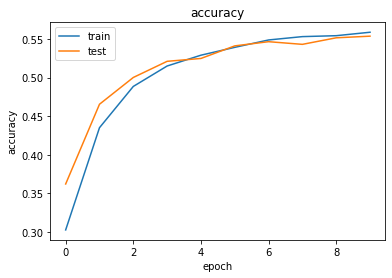

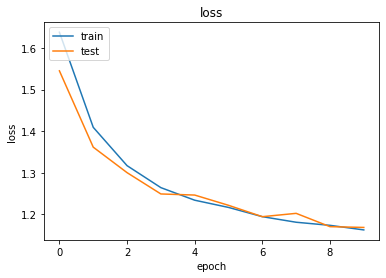

In [12]:
for x in ["accuracy", "loss"]:
    plt.plot(hist.history[x])
    plt.plot(hist.history[f"val_{x}"])
    plt.title(x)
    plt.ylabel(x)
    plt.xlabel("epoch")
    plt.legend(["train", "test"], loc="upper left")
    plt.show()


In [13]:
y_pred_prob = model.predict(X_test)
y_pred = [np.argmax(x) for x in y_pred_prob]

__ = {}
for k in y_pred:
    if __.get(k) == None:
        __[k] = 0
    __[k] += 1

print(__) ## sadly model recognises all text as business

{3: 2438, 6: 1955, 0: 1722, 5: 699, 2: 2197, 1: 301, 4: 127}


In [14]:
## change back to words instead of 0-6
y_pred = [y_map[x] for x in y_pred]
y_test = [y_map[x] for x in y_test]

In [15]:
accuracy = metrics.accuracy_score(y_test, y_pred)
roc = metrics.roc_auc_score(y_test, y_pred_prob, multi_class="ovr")
class_report = metrics.classification_report(y_test, y_pred)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)


# Visualisations

In [16]:
print(class_report)


              precision    recall  f1-score   support

    business       0.55      0.47      0.51      2000
    consumer       0.68      0.70      0.69       291
     finance       0.57      0.63      0.60      2000
     general       0.56      0.69      0.62      2000
  healthcare       0.42      0.20      0.27       268
     science       0.60      0.46      0.52       912
        tech       0.54      0.53      0.54      1968

    accuracy                           0.56      9439
   macro avg       0.56      0.53      0.53      9439
weighted avg       0.56      0.56      0.56      9439



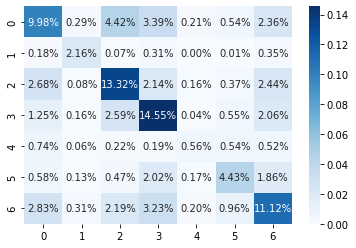

In [17]:
sns.heatmap(
    confusion_matrix / np.sum(confusion_matrix), fmt=".2%", annot=True, cmap="Blues"
)
plt.show()


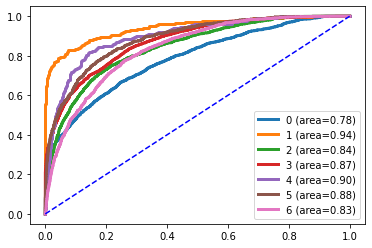

In [18]:
## https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
classes = [x for x in range(7)]
y_test_array = pd.get_dummies(y_test, drop_first=False).values
fig, ax = plt.subplots()
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:, i], y_pred_prob[:, i])
    ax.plot(
        fpr,
        tpr,
        lw=3,
        label="{0} (area={1:0.2f})".format(classes[i], metrics.auc(fpr, tpr)),
    )
ax.plot([0, 1], [0, 1], color="blue", linestyle="--")
ax.legend()


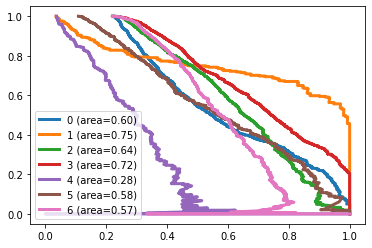

In [19]:
y_test_array = pd.get_dummies(y_test, drop_first=False).values
fig, ax = plt.subplots()
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
        y_test_array[:, i], y_pred_prob[:, i]
    )
    ax.plot(
        precision,
        recall,
        lw=3,
        label="{0} (area={1:0.2f})".format(classes[i], metrics.auc(recall, precision)),
    )
ax.legend()
